<a href="https://www.kaggle.com/code/khoatran311/yearly-and-weekly-seasonality-in-playground?scriptVersionId=215727147" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
library(tidyverse)
library(patchwork)
library(data.table)
theme_custom <- theme_classic() +
                theme(## Axis labels
                      axis.text.x = element_text(size=18, family="Econ Sans Cnd light"),
                      axis.text.y = element_text(size=18, family="Econ Sans Cnd light"),
                      ## Title, subtitle, caption, legend
                      plot.title = element_text(size=22, face="bold", family="Econ Sans Cnd bold", 
                                                hjust = 0, vjust = 1, margin = margin(b = 10)),
                      plot.subtitle = element_text(size=18, family="Econ Sans Cnd regular",
                                                   hjust = 0),
                      plot.caption = element_text(size=12, face="bold", family="Econ Sans Cnd light", hjust=0, colour="#6F8793"),
                      legend.position = "top",
                      legend.text = element_text(size=15, hjust=0, vjust=.1),
                      legend.title = element_blank(),
                      ## y-axis lines
                      panel.grid.major.y = element_line(color="#6F8793")
                     )
                     
figsize <- function(width=22, heigth=8){
    options(repr.plot.width=width, repr.plot.height=heigth)
}
figsize()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘data.table’




The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year




The following objects are masked from ‘package:dplyr’:

    between, first, last




The following object is masked from ‘package:purrr’:

    transpose




In [2]:
train <- read_csv("/kaggle/input/playground-series-s5e1/train.csv")

head(train, 4)
spec(train)

Rows: 230130 Columns: 6


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): country, store, product
dbl  (2): id, num_sold
date (1): date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,date,country,store,product,num_sold
<dbl>,<date>,<chr>,<chr>,<chr>,<dbl>
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NA
1,2010-01-01,Canada,Discount Stickers,Kaggle,973
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906
3,2010-01-01,Canada,Discount Stickers,Kerneler,423


cols(
  id = col_double(),
  date = col_date(format = ""),
  country = col_character(),
  store = col_character(),
  product = col_character(),
  num_sold = col_double()
)

In [3]:
## 1. Fill missing NA values in num_sold
## 2. Removes id feature
## 3. Extracts relevant datetime features
## 4. Glues country, store, product values together
train <- 
    train %>%
    ## Fill missing NA values in num_sold
    mutate(
        num_sold = case_when(
            country=="Canada" & is.na(num_sold) ~ exp(6.56),
            country=="Kenya" & is.na(num_sold)  ~ exp(2.83),
            .default=num_sold
        )
    ) %>%
    select(!id) %>%
    ## Extracts relevant datetime features
    mutate("month" = month(date),
           "day" = day(date),
           "year" = year(date),
           "quarter" = quarter(date)
          ) %>%
    data.table()

train <- 
    train %>%
    mutate("country_store_product" = paste(country, "_", store, "_", product, sep=""))

# Data Analysis 
### 1. Target distribution is most distinctive for Kenya than other countries
### 2. All series are non-stationary
### 3. Mean number of items sold by Norway and Kenya are easily separable from other countries (theoretically, easier to forecast)
### 4. Separated by countries, seasonality in sales pattern repeat every 12 months and every 7 days

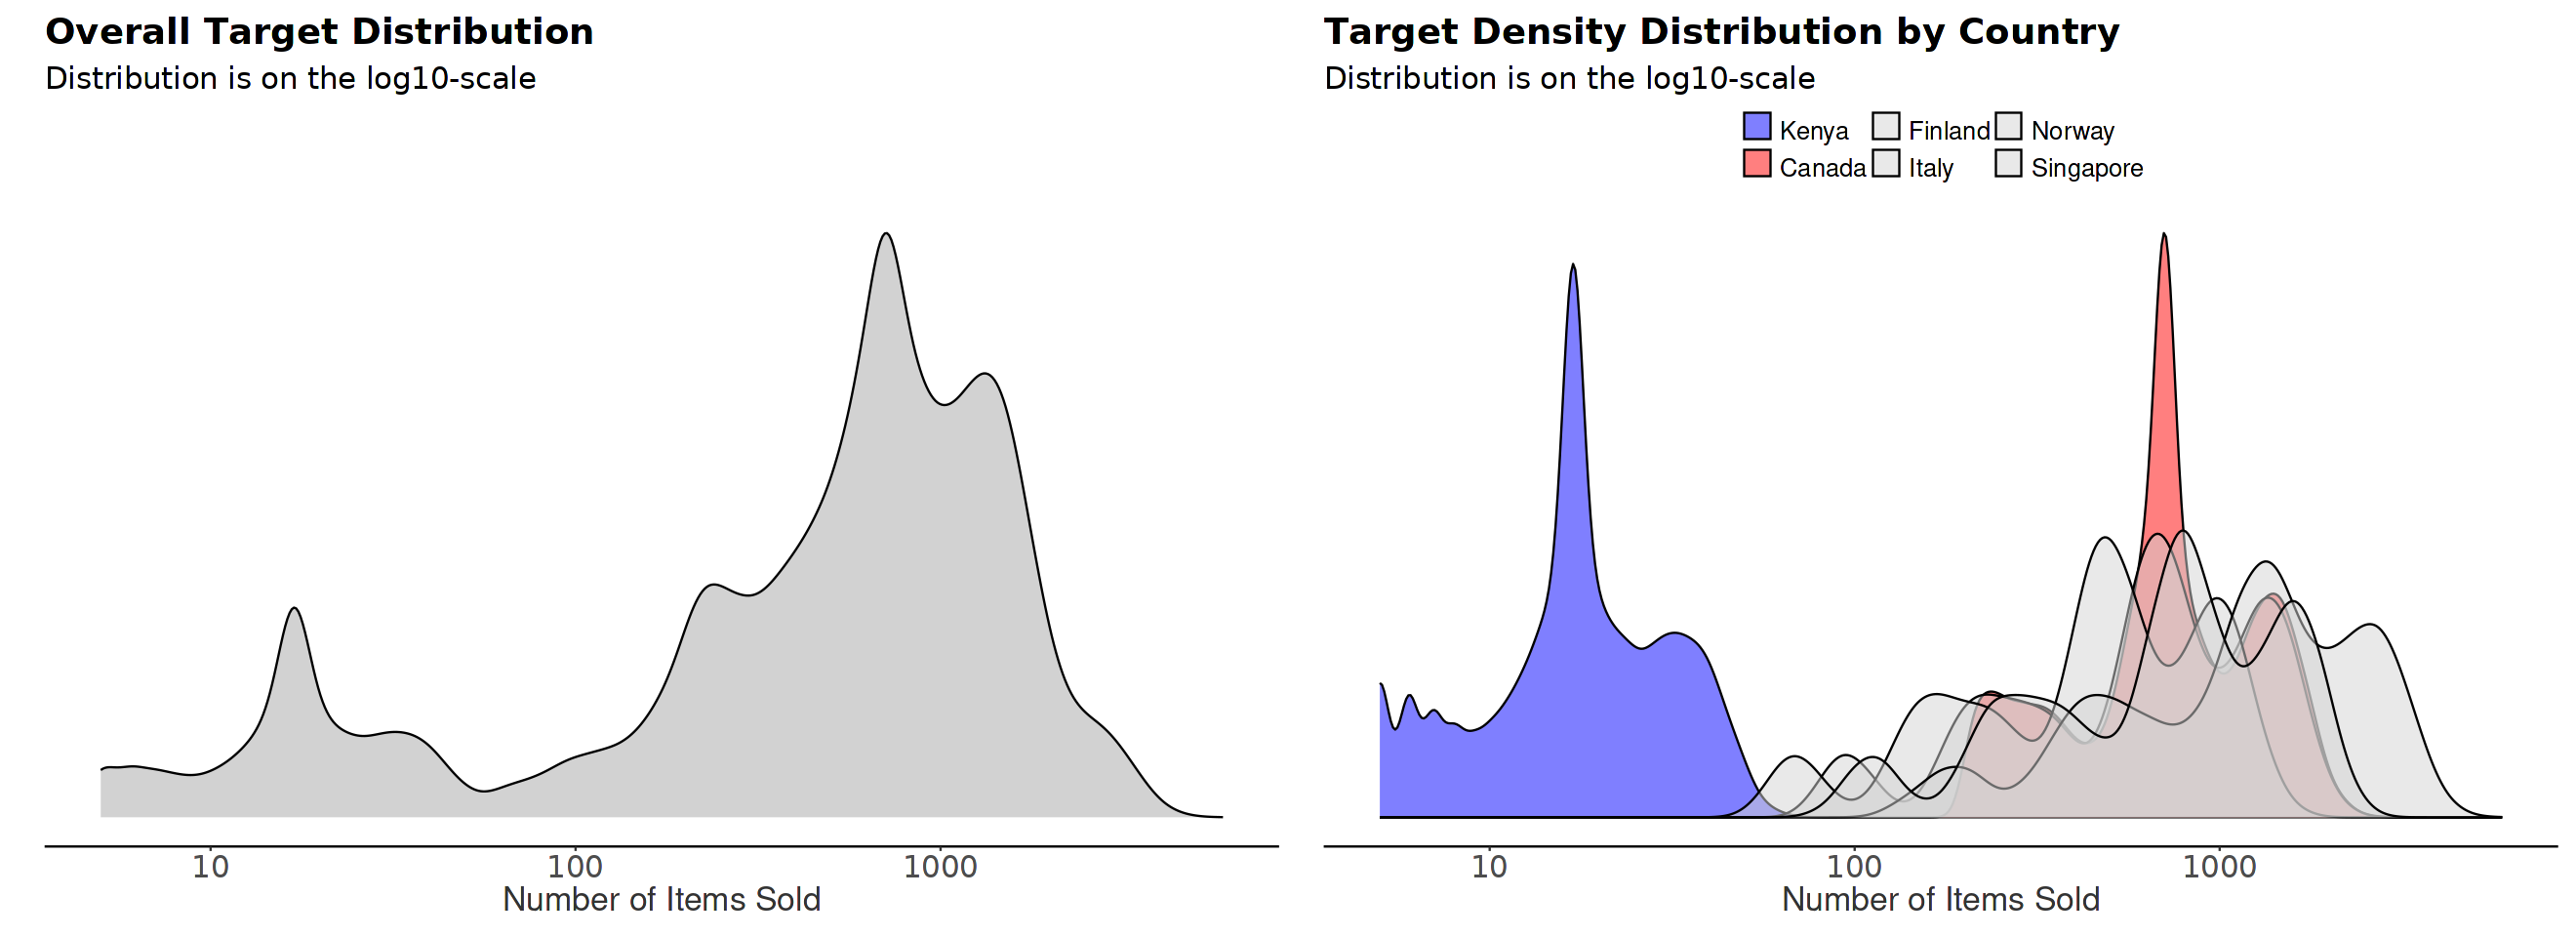

In [4]:
overall_dist <- 
    train %>%
    ggplot(aes(x=num_sold)) +
    geom_density(alpha=.7, fill="gray", color="black") +
    scale_x_log10() +
    labs(title="Overall Target Distribution",
         subtitle="Distribution is on the log10-scale",
         x="Number of Items Sold",
         y=""
        ) +
    theme_custom +
    theme(panel.grid.major.y=element_blank(),
          axis.line.y=element_blank(),
          axis.title.x=element_text(size=20, color="#333333"),
          axis.ticks.y=element_blank(),
          axis.text.y=element_blank()
         )



country_levels <- c("Kenya", "Canada", "Finland", "Italy", "Norway", "Singapore")
country_dists <-
    train %>%
    mutate(country=factor(country, levels=country_levels)) %>%
    ### Graphing
    ggplot(aes(x=num_sold, fill=country)) +
    geom_density(alpha=.5, color="black") +
    scale_x_log10() +
    theme_custom +
    labs(title="Target Density Distribution by Country",
         subtitle="Distribution is on the log10-scale",
         x="Number of Items Sold",
         y=""
        ) +
    theme(panel.grid.major.y=element_blank(),
          axis.line.y=element_blank(),
          axis.title.x=element_text(size=20, color="#333333"),
          axis.ticks.y=element_blank(),
          axis.text.y=element_blank()
         ) +
    scale_fill_manual(
        values=c("Kenya"="blue", 
                 "Canada"="red", 
                 "Finland"="#D3D3D3",
                 "Italy"="#D3D3D3",
                 "Norway"="#D3D3D3",
                 "Singapore"="#D3D3D3"
                )
    )


overall_dist + country_dists

In [5]:
### Obtains average sales per country per date and the std
reduced_df <- 
    train %>%
    group_by(date, country) %>%
    summarise("mean_num_sold" = mean(num_sold),
              "sd_num_sold" = sd(num_sold)
             )

head(reduced_df, 10)

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


date,country,mean_num_sold,sd_num_sold
<date>,<chr>,<dbl>,<dbl>
2010-01-01,Canada,1053.68478,612.01812
2010-01-01,Finland,1024.00000,679.67671
2010-01-01,Italy,776.33333,500.97914
2010-01-01,Kenya,20.66303,11.84946
2010-01-01,Norway,1861.53333,1168.99730
2010-01-01,Singapore,1016.40000,651.43115
2010-01-02,Canada,1036.48478,617.89980
2010-01-02,Finland,956.80000,624.67594
2010-01-02,Italy,725.86667,452.71859


Saving 12.5 x 6.67 in image


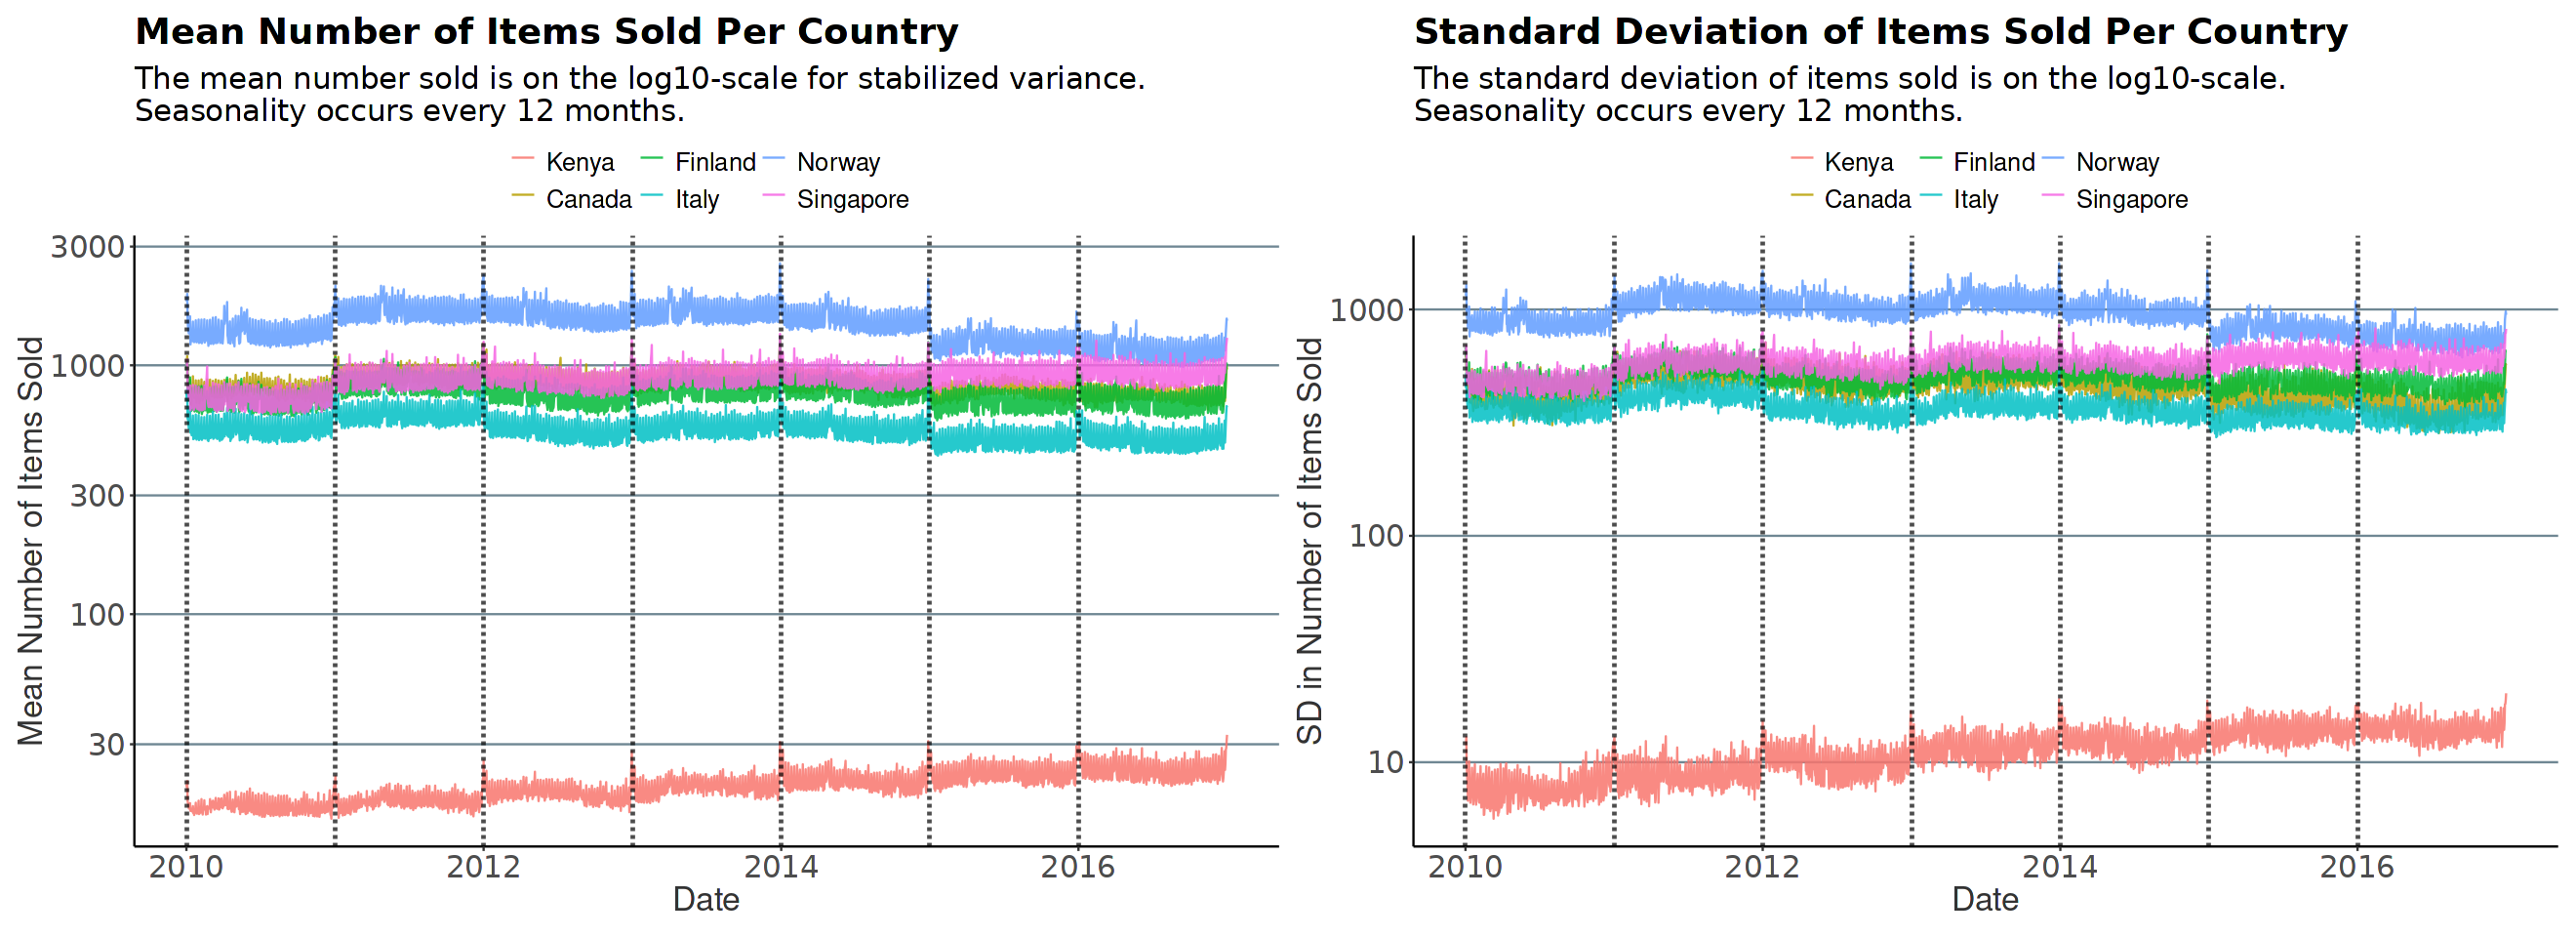

In [6]:
country_levels <- c("Kenya", "Canada", "Finland", "Italy", "Norway", "Singapore")
highlight_dates <- as.Date(c("2010-01-01", "2011-01-01", "2012-01-01",
                             "2013-01-01", "2014-01-01", "2015-01-01",
                             "2016-01-01"
                            ))

mean_graph <- reduced_df %>%
    mutate(country=factor(country, levels=country_levels)) %>%
    ggplot(aes(x=date, y=mean_num_sold)) +
    geom_line(aes(color=country), alpha=.85) +
    theme_custom +
    scale_y_log10() +
    labs(title="Mean Number of Items Sold Per Country",
         subtitle="The mean number sold is on the log10-scale for stabilized variance.\nSeasonality occurs every 12 months.",
         x="Date",
         y="Mean Number of Items Sold"
        ) +
    geom_vline(xintercept=highlight_dates, linetype="dashed", color="black", linewidth=1, alpha=.7) +
    theme(axis.title.x = element_text(size=20, color="#333333"),
          axis.title.y = element_text(size=20, color="#333333")
         )


sd_graph <- reduced_df %>%
    mutate(country=factor(country, levels=country_levels)) %>%
    ggplot(aes(x=date, y=sd_num_sold)) +
    geom_line(aes(color=country), alpha=.85) +
    theme_custom +
    scale_y_log10() +
    labs(title="Standard Deviation of Items Sold Per Country",
         subtitle="The standard deviation of items sold is on the log10-scale.\nSeasonality occurs every 12 months.",
         x="Date",
         y="SD in Number of Items Sold"
        ) +
    geom_vline(xintercept=highlight_dates, linetype="dashed", color="black", linewidth=1, alpha=.7) +
    theme(axis.title.x = element_text(size=20, color="#333333"),
          axis.title.y = element_text(size=20, color="#333333")
         )

mean_graph + sd_graph
ggsave("mean_std_num_sold.png", plot=last_plot(), dpi=300)

Saving 12.5 x 6.67 in image


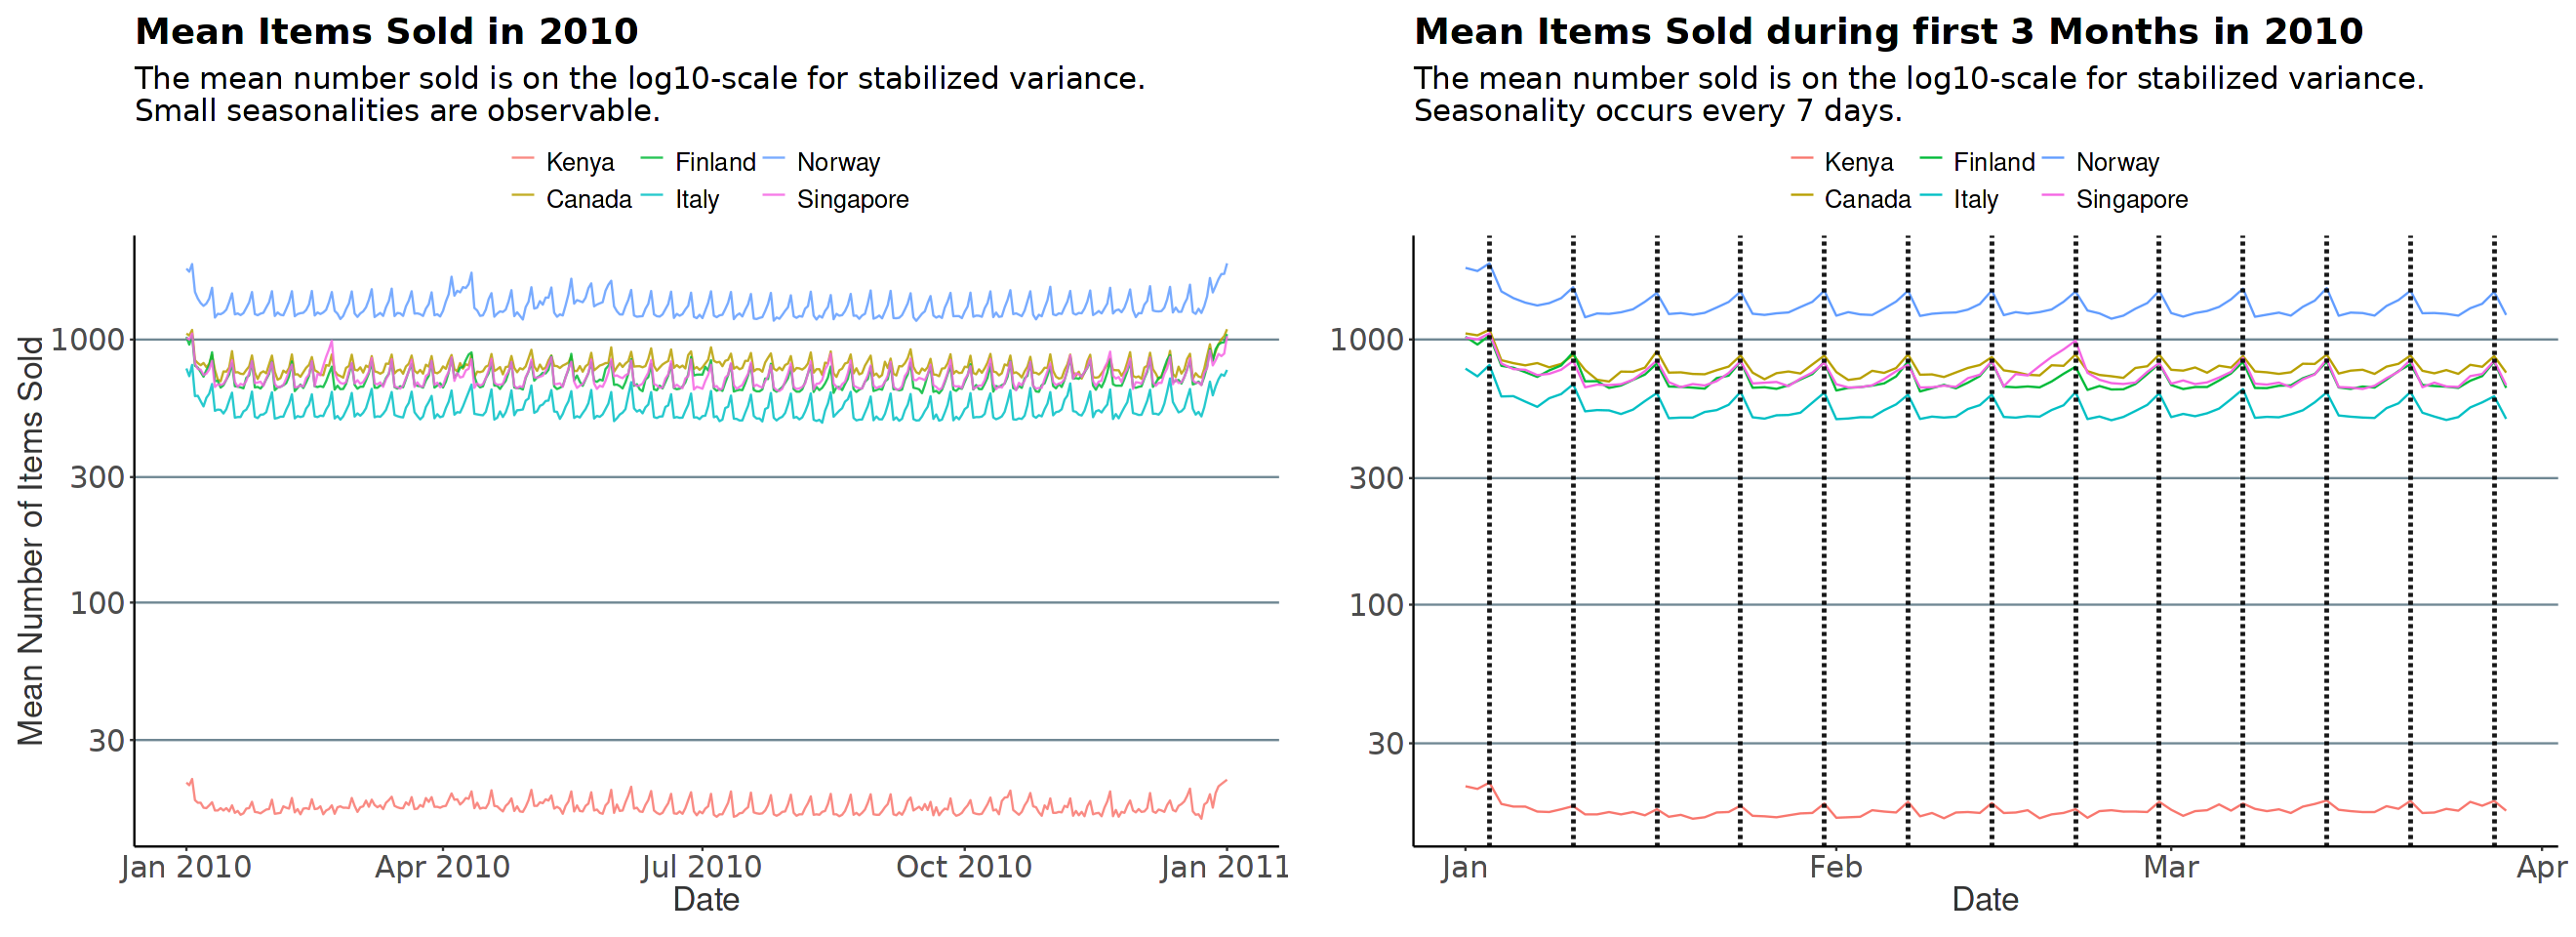

In [7]:
year_graph <- 
    reduced_df %>%
    filter(date <= as.Date("2011-01-01")) %>%
    mutate(country=factor(country, levels=country_levels)) %>%
    ggplot(aes(x=date, y=mean_num_sold)) +
    geom_line(aes(color=country), alpha=.85) +
    theme_custom +
    scale_y_log10() +
    labs(title="Mean Items Sold in 2010",
         subtitle="The mean number sold is on the log10-scale for stabilized variance.\nSmall seasonalities are observable.",
         x="Date",
         y="Mean Number of Items Sold"
        ) +
    theme(axis.title.x = element_text(size=20, color="#333333"),
          axis.title.y = element_text(size=20, color="#333333")
         )


highlight_dates <- as.Date(c("2010-01-03", "2010-01-10", "2010-01-17", "2010-01-24", "2010-01-31",
                             "2010-02-07", "2010-02-14", "2010-02-21", "2010-02-28",
                             "2010-03-7", "2010-03-14", "2010-03-21", "2010-03-28"
                            ))
week_graph <- 
    reduced_df %>%
    filter(date < as.Date("2010-03-30")) %>%
    mutate(country=factor(country, levels=country_levels)) %>%
    ggplot(aes(x=date, y=mean_num_sold)) +
    geom_line(aes(color=country)) +
    theme_custom +
    scale_y_log10() +
    labs(title="Mean Items Sold during first 3 Months in 2010",
         subtitle="The mean number sold is on the log10-scale for stabilized variance.\nSeasonality occurs every 7 days.",
         x="Date",
         y=""
        ) +
    geom_vline(xintercept=highlight_dates, linetype="dashed", color="black", linewidth=1, alpha=.7) +
    theme(axis.title.x = element_text(size=20, color="#333333"),
          axis.title.y = element_text(size=20, color="#333333")
         ) +
     geom_vline(xintercept=highlight_dates, linetype="dashed", color="black", linewidth=1, alpha=.7) 


year_graph + week_graph
ggsave("year_week_num_sold.png", plot=last_plot(), dpi=300)

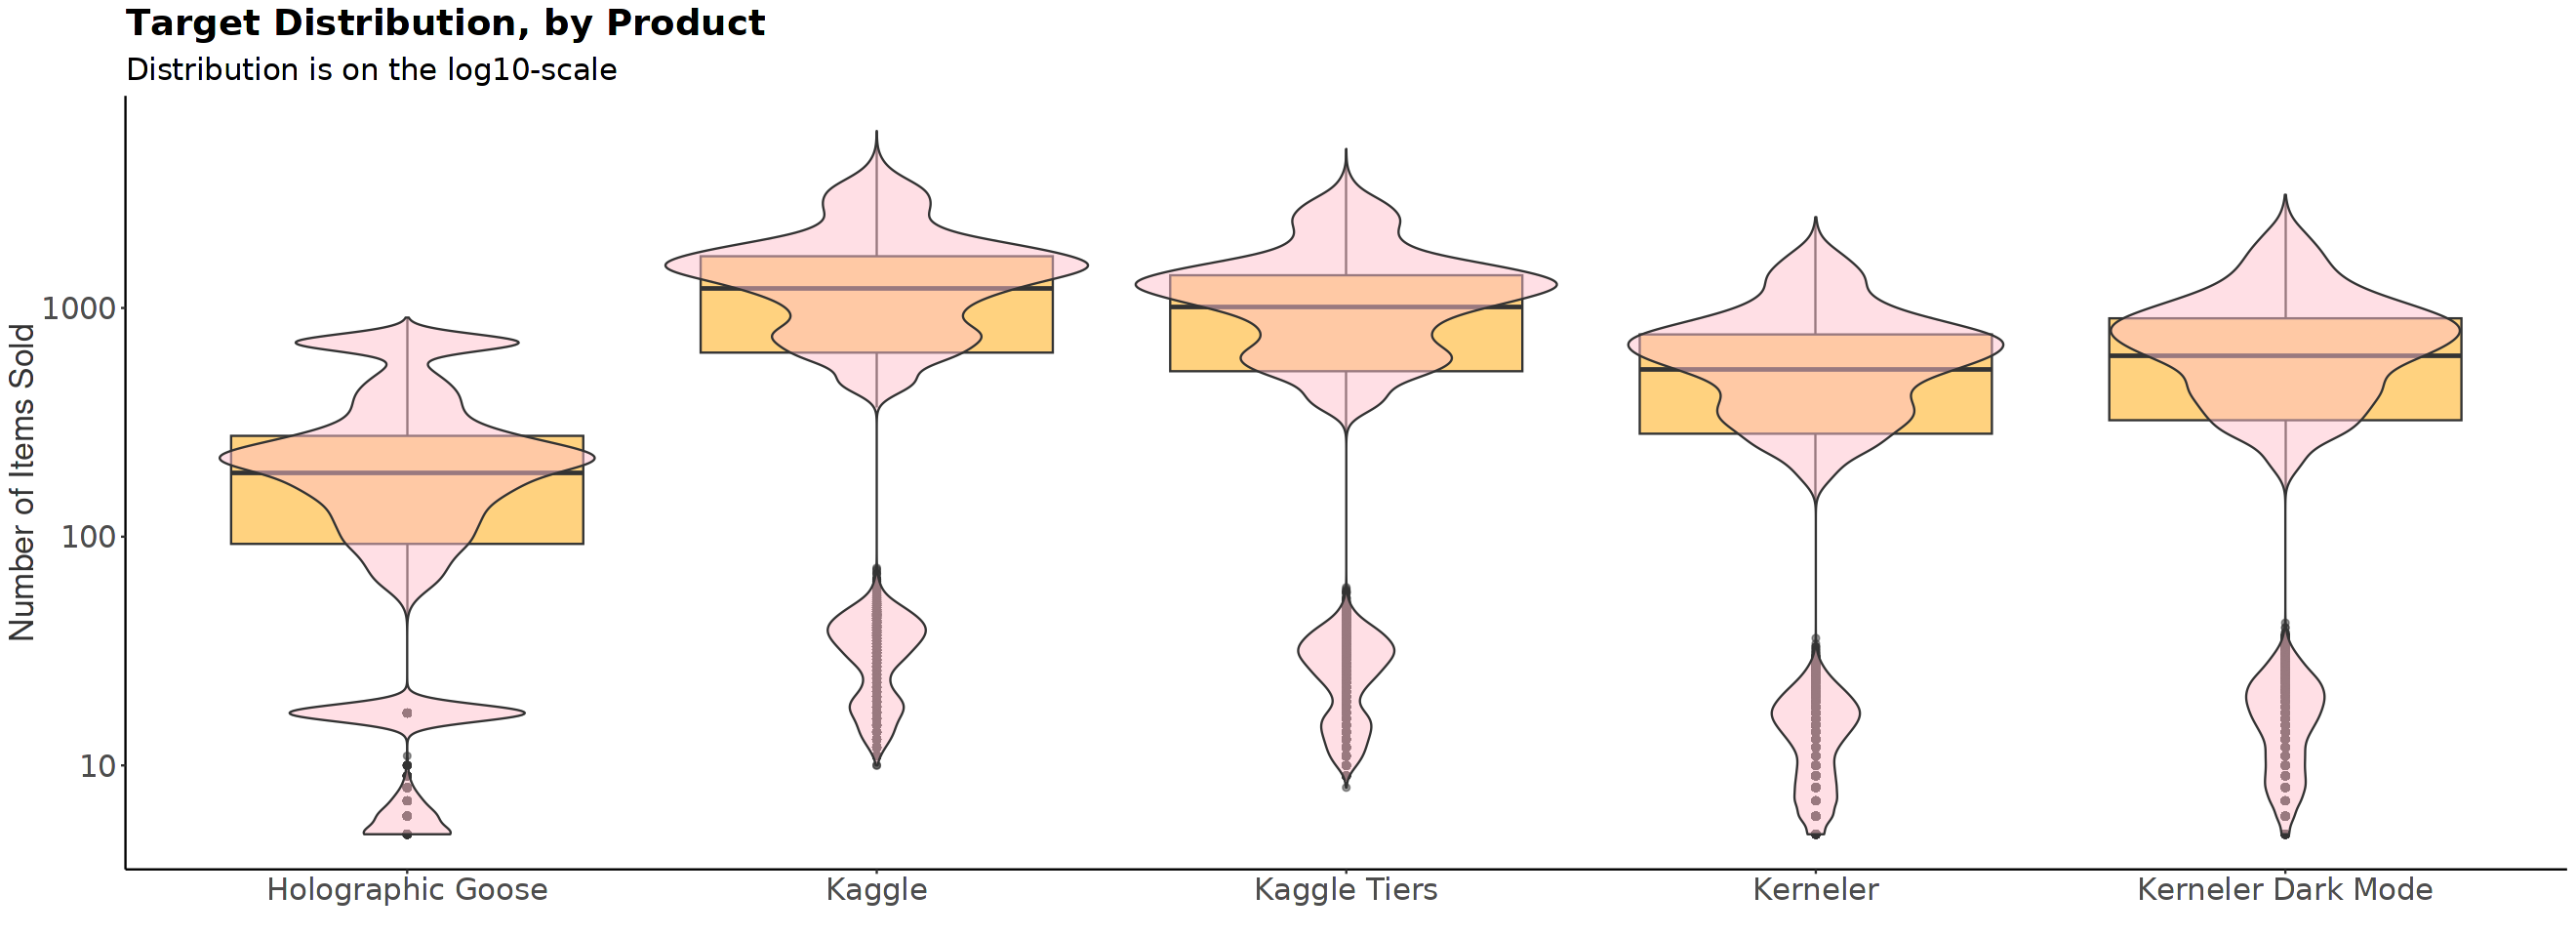

In [8]:
train %>%
    ggplot(aes(x=product, y=num_sold)) +
    geom_boxplot(fill="orange", alpha=.5) +
    geom_violin(fill="pink", alpha=.5) +
    scale_y_log10() +
    labs(title="Target Distribution, by Product", 
         subtitle="Distribution is on the log10-scale",
         x="",
         y="Number of Items Sold"
        ) +
    theme_custom +
    theme(panel.grid.major.y = element_blank(),
          axis.title.y = element_text(size=20, color="#333333")
         )

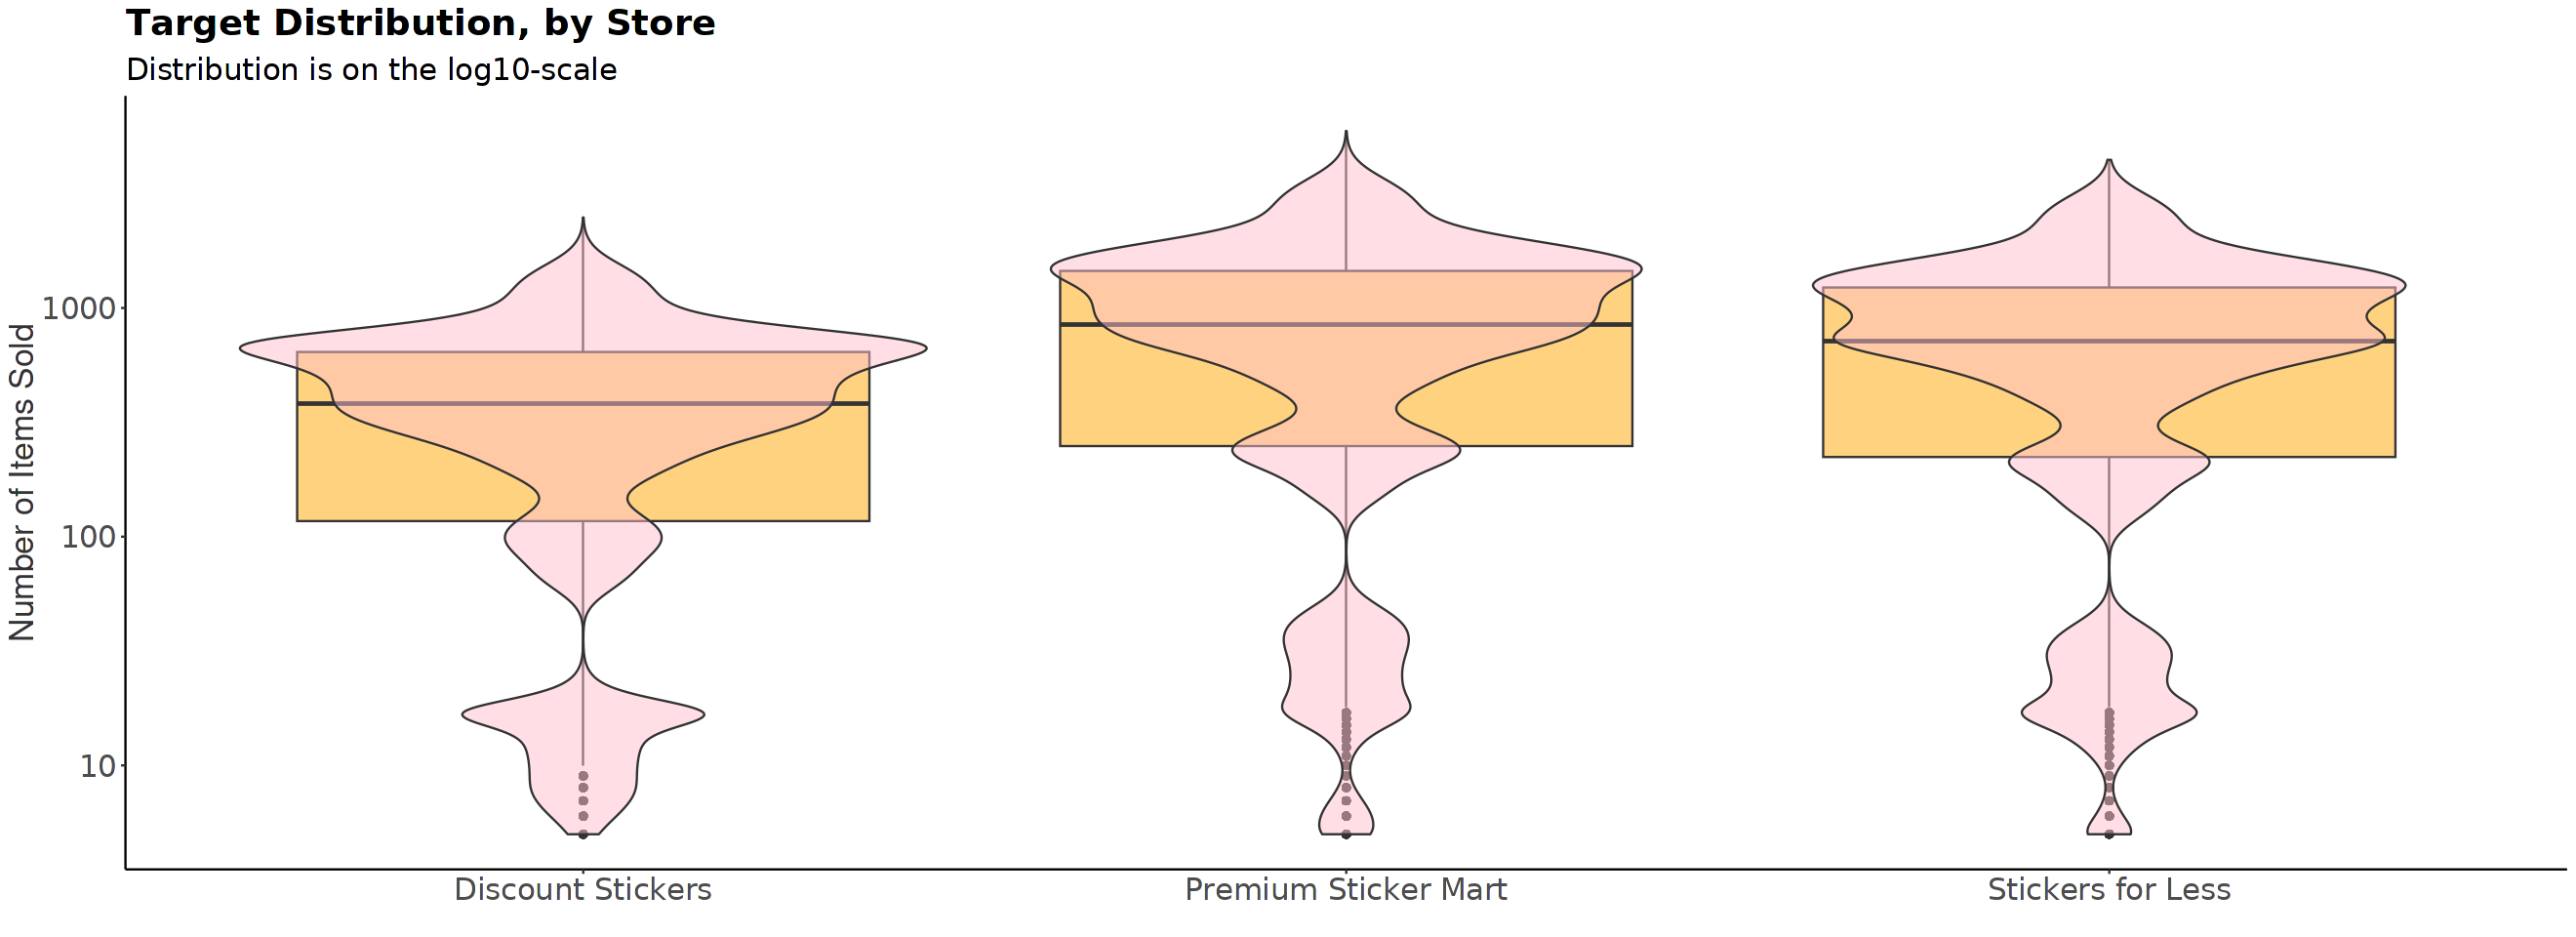

In [9]:
train %>%
    ggplot(aes(x=store, y=num_sold)) +
    geom_boxplot(fill="orange", alpha=.5) +
    geom_violin(fill="pink", alpha=.5) +
    scale_y_log10() +
    labs(title="Target Distribution, by Store", 
         subtitle="Distribution is on the log10-scale",
         x="",
         y="Number of Items Sold"
        ) +
    theme_custom +
    theme(panel.grid.major.y = element_blank(),
          axis.title.y = element_text(size=20, color="#333333")
         )

In [10]:
###
# These are estimations of possible regions with seasonality observed in the data when inspecting only countries;
# other seasonalities could still exist in other variables, such as product and store.
###

final_df <- 
    train %>%
    mutate("global_yearly_seasonality" = if_else((month==12&day==31) | (month==1&day==1), 1, 0),
           "global_weekly_seasonality" = case_when(month==1 & day%%7==3 ~ 1,
                                                   month!=1 & day%%7==0 ~ 1,
                                                   .default = 0
                                           )
          ) %>%
    mutate("store_product" = paste(store, "_", product, sep=""))

In [11]:
head(final_df)

date,country,store,product,num_sold,month,day,year,quarter,country_store_product,global_yearly_seasonality,global_weekly_seasonality,store_product
<date>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>
2010-01-01,Canada,Discount Stickers,Holographic Goose,706.2717,1,1,2010,1,Canada_Discount Stickers_Holographic Goose,1,0,Discount Stickers_Holographic Goose
2010-01-01,Canada,Discount Stickers,Kaggle,973.0000,1,1,2010,1,Canada_Discount Stickers_Kaggle,1,0,Discount Stickers_Kaggle
2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0000,1,1,2010,1,Canada_Discount Stickers_Kaggle Tiers,1,0,Discount Stickers_Kaggle Tiers
2010-01-01,Canada,Discount Stickers,Kerneler,423.0000,1,1,2010,1,Canada_Discount Stickers_Kerneler,1,0,Discount Stickers_Kerneler
2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0000,1,1,2010,1,Canada_Discount Stickers_Kerneler Dark Mode,1,0,Discount Stickers_Kerneler Dark Mode
2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0000,1,1,2010,1,Canada_Stickers for Less_Holographic Goose,1,0,Stickers for Less_Holographic Goose
